In [1]:
import pandas as pd
import numpy as np
f=open('./最终数据集.csv')
data_combined=pd.read_csv(f)
data15 = data_combined.iloc[:62391,:]    #由于原本的最终数据集是把15和21风机按前后顺序合并再清洗，这里直接按各自原数据集的大小截取两个风机的数据
data21 = data_combined.iloc[62391:,:]
#之前特征选取的依据是在特征工程中我们根据物理意义人为构造出了如力矩、扭矩等可解释的新特征，把这些特征直接用于模型训练的缺点在于忽视了高维度的特征关系，
#如time和wind_speed两个特征交互出的新特征（在某个特定时间的风速）是否能对结冰做出更好的解释？基于这样的想法，可以考虑把特征训练的工作交给模型自身
#这里分别采用了随机森林和GBDT两种决策树学习的方式来构造新特征（缺点是无监督学习出来的新特征的解释性差），然后把新特征交给LR模型训练，最后在21号风机上测试取得了比较好的效果。

In [6]:
#分别采用RF,RF+LR,GBDT,GBDT+LR预测
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix
from sklearn.pipeline import make_pipeline

In [7]:
#选择训练特征，考虑到group的存在可能导致模型过拟合这里没有选入训练，这里的time经过切割只保留了小时数。
train_features=['time', 'wind_speed', 'generator_speed', 'power', 'wind_direction',
       'wind_direction_mean', 'pitch1_moto_tmp', 'pitch2_moto_tmp',
       'pitch3_moto_tmp', 'acc_x', 'acc_y', 'environment_tmp', 'int_tmp',
       'pitch1_ng5_tmp', 'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC',
       'pitch2_ng5_DC', 'pitch3_ng5_DC', 'pitch_speed_ave']

In [8]:
# 处理测试集
test_x=data21[train_features]
test_y=data21['Label']

In [9]:
# 将样本集分成训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(data15[train_features], data15['Label'], test_size=0.5)
# 再将训练集拆成两个部分（GBDT/RF，LR）
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
#再划分的目的在于防止学习过程中的标签泄露，前2W个只学习特征划分，后2W个通过LR对特征的重要程度排序
#基于随机森林的监督变换
n_estimators=10  #设置分类器数为10
rf = RandomForestClassifier(max_depth=3,
                            n_estimators=n_estimators)
rf.fit(X_train,y_train)
#得到OneHot编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train))
#使用OneHot编码作为特征训练LR
rf_lm = LogisticRegression(solver='lbfgs',max_iter=1000)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)),y_train_lr)

#使用RF_LR进行预测，返回预测所有样本标签为1（结冰）的概率数组
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(test_x)))[:,1]
fpr_rf_lm,tpr_rf_lm,_ = roc_curve(test_y,y_pred_rf_lm)

#基于GBDT监督变换
grd = GradientBoostingClassifier(n_estimators=n_estimators)
grd.fit(X_train,y_train)
#OneHot编码
grd_enc = OneHotEncoder(categories='auto')
grd_enc.fit(grd.apply(X_train)[:, :, 0])
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
# 使用GBDT_LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(test_x)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(test_y, y_pred_grd_lm)
# 直接使用GBDT进行预测
y_pred_grd = grd.predict_proba(test_x)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(test_y, y_pred_grd)

# 直接使用RF进行预测
y_pred_rf = rf.predict_proba(test_x)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(test_y, y_pred_rf)

# 直接使用LR进行预测
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_y, y_pred)

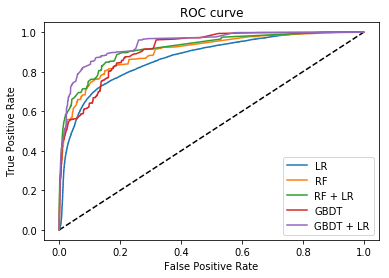

In [10]:
#绘制ROC曲线
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBDT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

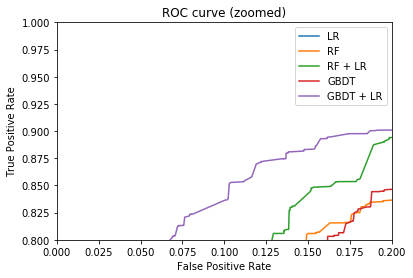

In [11]:
# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBDT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()

In [12]:
#输出各模型AUC得分，可以看到先用GBDT自动学习新特征再用LR对特征筛选排序的效果最好。
auc_lr = roc_auc_score(test_y, y_pred)
auc_rf = roc_auc_score(test_y, y_pred_rf)
auc_rflm = roc_auc_score(test_y, y_pred_rf_lm)
auc_gbdt = roc_auc_score(test_y, y_pred_grd)
auc_gbdtlr = roc_auc_score(test_y, y_pred_grd_lm)
print('LogisticRegression: ', auc_lr)
print('RandomForest: ', auc_rf)
print('RandomForest+LogisticRegression: ', auc_rflm)
print('GBDT: ',auc_gbdt)
print('GBDT+LogisticRegression: ', auc_gbdtlr)

LogisticRegression:  0.8704855970055791
RandomForest:  0.901962561572955
RandomForest+LogisticRegression:  0.9181754134555556
GBDT:  0.9097837519850805
GBDT+LogisticRegression:  0.9429678298559526


In [13]:
from sklearn.model_selection import cross_val_score
#调用交叉验证评估模型准确率
scores_lr=cross_val_score(LR,data21[train_features],data21['Label'],cv=5)
scores_rf=cross_val_score(rf,data21[train_features],data21['Label'],cv=5)
scores_grd=cross_val_score(grd,data21[train_features],data21['Label'],cv=5)
scores_rf_lm=cross_val_score(rf_lm,data21[train_features],data21['Label'],cv=5)
scores_grd_lm = cross_val_score(grd_lm,data21[train_features],data21['Label'],cv=5)

print('scores_lr K折交叉验证准确率：\n',scores_lr)
print('scores_rf K折交叉验证准确率：\n',scores_rf)
print('scores_grd K折交叉验证准确率：\n',scores_grd)
print('scores_rf_lm K折交叉验证准确率：\n',scores_rf_lm)
print('scores_grd_lm K折交叉验证准确率：\n',scores_grd_lm)

scores_lr K折交叉验证准确率：
 [0.56799145 0.85278916 0.83425414 0.77112299 0.6828877 ]
scores_rf K折交叉验证准确率：
 [0.57815006 0.89752272 0.8814828  0.88609626 0.67557932]
scores_grd K折交叉验证准确率：
 [0.6802709  0.87845304 0.91748351 0.81746881 0.89625668]
scores_rf_lm K折交叉验证准确率：
 [0.60648726 0.86437355 0.83746213 0.77557932 0.7114082 ]
scores_grd_lm K折交叉验证准确率：
 [0.60648726 0.86437355 0.83746213 0.77557932 0.7114082 ]


In [1]:
history

history
